<a href="https://colab.research.google.com/github/Gheras13/Homework/blob/main/Homework_1_5r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MACHINE LEARNING HOMEWORK 1

#DIRECT KINEMATICS OF ROBOT MANIPLUATOR

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# Generate Data

In [3]:


# Percorso del file CSV
file_path = '/content/drive/My Drive/File_csv/Copia di r5_20_100k.csv'
# Caricamento dataset
dataset = pd.read_csv(file_path, sep=';', header=0)

dataset.columns = dataset.columns.str.strip()
#prendo i primi 30000 samples
df = dataset.iloc[:30000]
print("Colonne disponibili nel dataset:", df.columns.tolist())

# Estrazione  feature (j0, j1) e i target (ee_x, ee_y)
X = df[['j0', 'j1','j2','j3','j4']].values  # Angoli articolari
Y = df[['ee_x', 'ee_y']].values  # Posizioni finali (end-effector)



Colonne disponibili nel dataset: ['j0', 'j1', 'j2', 'j3', 'j4', 'cos(j0)', 'cos(j1)', 'cos(j2)', 'cos(j3)', 'cos(j4)', 'sin(j0)', 'sin(j1)', 'sin(j2)', 'sin(j3)', 'sin(j4)', 'ee_x', 'ee_y', 'ee_z', 'ee_qw', 'ee_qx', 'ee_qy', 'ee_qz']


In [4]:
# Divisione dati in training e testing
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


# Test del modello

In [5]:
def build_model(hidden_neurons, learning_rate, dropout_rate=None, l2_lambda=None):
    layers = [
        tf.keras.layers.Dense(
            hidden_neurons, activation='relu', input_shape=(5,),
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda) if l2_lambda else None
        )
    ]

    if dropout_rate:
        layers.append(tf.keras.layers.Dropout(dropout_rate))  # Aggiunta Dropout

    layers.extend([
        tf.keras.layers.Dense(
            hidden_neurons, activation='relu',
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda) if l2_lambda else None
        ),
        tf.keras.layers.Dense(2)
    ])

    model = tf.keras.Sequential(layers)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae']
    )
    return model


 Configurazione del modello per l'addestramento:
 - Ottimizzatore: Adam (learning_rate=0.01).
 - Funzione di perdita: Mean Squared Error (MSE).
 - Metriche: Mean Absolute Error (MAE).


# Valutazione finale del modello sul set di test.
# Metriche:
# - `loss`: Errore quadratico medio (MSE), risulterà essere la nostra LOSS FUNCTION.
# - `mae`: Errore assoluto medio.
# Come SOLVER è stato scelto ADAM


#GRID SEARCH

In [6]:
from itertools import product

# Parametri per il tuning del modello base
hidden_layers = [64, 128]
learning_rates = [0.01, 0.001]

results = []

print("Tuning sul modello base...")
for hl, lr in product(hidden_layers, learning_rates):
    print(f"Test sul modello {hl} hidden neurons e {lr} learning rate")
    model_baseline = build_model(hidden_neurons=hl, learning_rate=lr)
    history = model_baseline.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
    loss, mae = model_baseline.evaluate(X_test, Y_test, verbose=0)
    results.append((hl, lr, loss, mae))

# miglior risultati
sorted_results = sorted(results, key=lambda x: x[2])
best_config = sorted_results[0]
print(f"Miglior configurazione trovata per il modello base: Neuroni Nascosti={best_config[0]}, Learning Rate={best_config[1]}")


Tuning sul modello base...
Test sul modello 64 hidden neurons e 0.01 learning rate


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Test sul modello 64 hidden neurons e 0.001 learning rate
Test sul modello 128 hidden neurons e 0.01 learning rate
Test sul modello 128 hidden neurons e 0.001 learning rate
Miglior configurazione trovata per il modello base: Neuroni Nascosti=128, Learning Rate=0.001


In [7]:
# Parametri ottimali trovati dal tuning
optimal_hidden_neurons = best_config[0]
optimal_learning_rate = best_config[1]

# Configurazioni per Dropout e Weight Decay
dropout_rate = 0.2
l2_lambda = 0.001
import time

# Lista per i risultati finali
final_results = []

# 1. Modello Base
print("\nAddestramento Modello Base...")
start_time = time.time()
model_baseline = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate)
history_baseline = model_baseline.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
end_time = time.time()
loss, mae = model_baseline.evaluate(X_test, Y_test, verbose=0)
training_time = end_time - start_time
final_results.append(('Baseline', loss, mae, training_time))
print(f"Tempo di allenamento Modello Base: {training_time:.2f} secondi")

# 2. Modello con Dropout
print("\nAddestramento Modello con Dropout...")
start_time = time.time()
model_dropout = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate, dropout_rate=dropout_rate)
history_dropout = model_dropout.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
end_time = time.time()
loss, mae = model_dropout.evaluate(X_test, Y_test, verbose=0)
training_time = end_time - start_time
final_results.append(('Dropout', loss, mae, training_time))
print(f"Tempo di allenamento Modello con Dropout: {training_time:.2f} secondi")

# 3. Modello con Weight Decay
print("\nAddestramento Modello con Weight Decay...")
start_time = time.time()
model_l2 = build_model(hidden_neurons=optimal_hidden_neurons, learning_rate=optimal_learning_rate, l2_lambda=l2_lambda)
history_l2 = model_l2.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=20, batch_size=32, verbose=0)
end_time = time.time()
loss, mae = model_l2.evaluate(X_test, Y_test, verbose=0)
training_time = end_time - start_time
final_results.append(('Weight Decay', loss, mae, training_time))
print(f"Tempo di allenamento Modello con Weight Decay: {training_time:.2f} secondi")

# Stampa dei risultati finali
print("\nConfronto Finale tra i Modelli:")
for res in final_results:
    print(f"Modello: {res[0]}, Loss: {res[1]:.4f}, MAE: {res[2]:.4f}, Tempo di Allenamento: {res[3]:.2f} secondi")



Addestramento Modello Base...
Tempo di allenamento Modello Base: 39.59 secondi

Addestramento Modello con Dropout...
Tempo di allenamento Modello con Dropout: 44.27 secondi

Addestramento Modello con Weight Decay...
Tempo di allenamento Modello con Weight Decay: 40.82 secondi

Confronto Finale tra i Modelli:
Modello: Baseline, Loss: 0.0000, MAE: 0.0055, Tempo di Allenamento: 39.59 secondi
Modello: Dropout, Loss: 0.0003, MAE: 0.0142, Tempo di Allenamento: 44.27 secondi
Modello: Weight Decay, Loss: 0.0016, MAE: 0.0185, Tempo di Allenamento: 40.82 secondi



Confronto Finale tra i Modelli:
Modello: Baseline, Loss: 0.0000, MAE: 0.0055
Modello: Dropout, Loss: 0.0003, MAE: 0.0142
Modello: Weight Decay, Loss: 0.0016, MAE: 0.0185


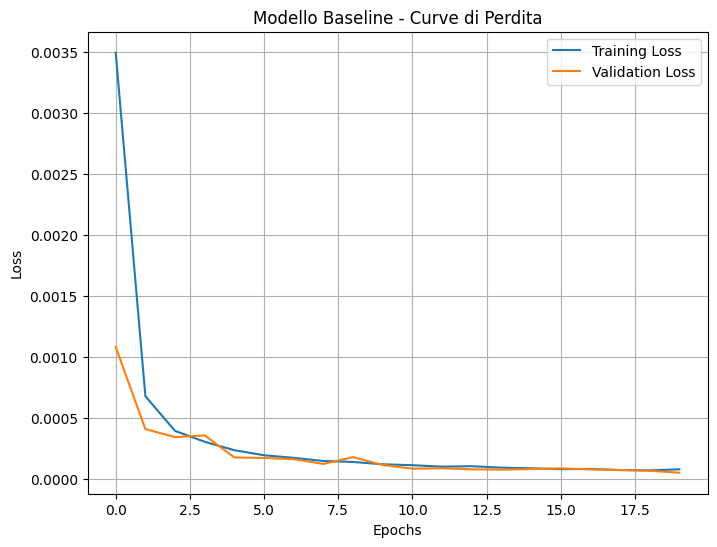

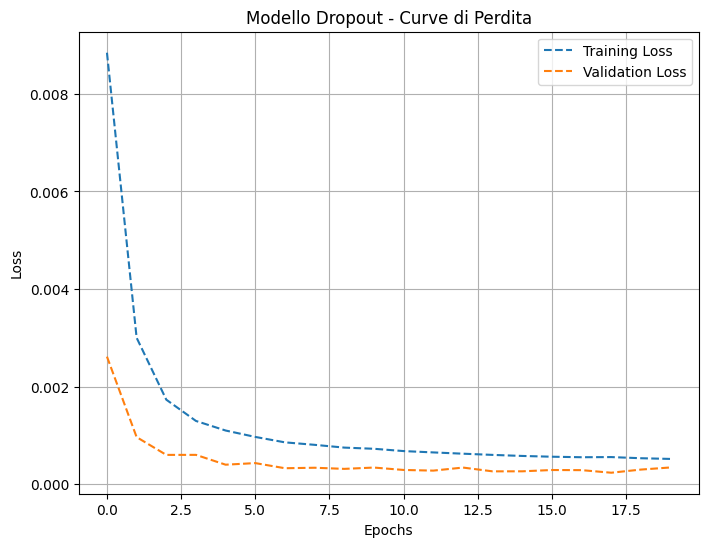

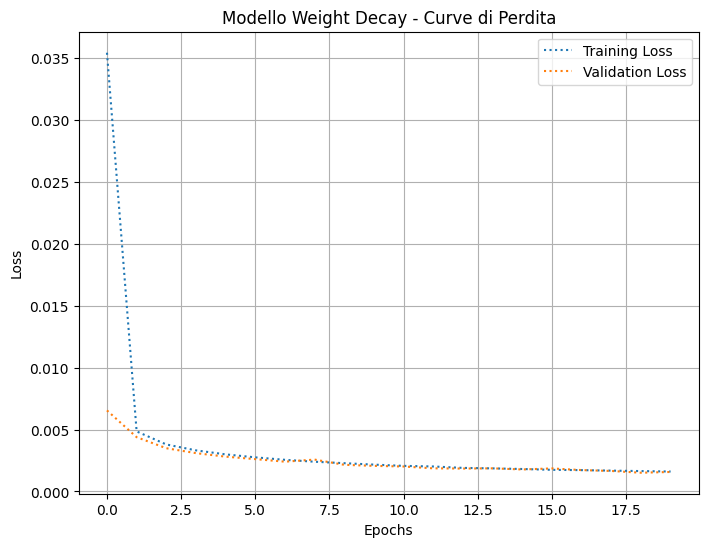

In [11]:

print("\nConfronto Finale tra i Modelli:")
for res in final_results:
    print(f"Modello: {res[0]}, Loss: {res[1]:.4f}, MAE: {res[2]:.4f}")

# Grafico per il Modello Base
plt.figure(figsize=(8, 6))
plt.plot(history_baseline.history['loss'], label='Training Loss')
plt.plot(history_baseline.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Baseline - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()

# Grafico per il Modello Dropout
plt.figure(figsize=(8, 6))
plt.plot(history_dropout.history['loss'], label='Training Loss', linestyle='dashed')
plt.plot(history_dropout.history['val_loss'], label='Validation Loss', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Dropout - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()

# Grafico per il Modello Weight Decay
plt.figure(figsize=(8, 6))
plt.plot(history_l2.history['loss'], label='Training Loss', linestyle='dotted')
plt.plot(history_l2.history['val_loss'], label='Validation Loss', linestyle='dotted')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modello Weight Decay - Curve di Perdita')
plt.legend()
plt.grid(True)
plt.show()


#Definizione dei jacobiani

In [9]:
@tf.function
def FK_Jacobian(model, x):
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x)
        y = FK(model, x)
    return tape.jacobian(y, x)

def FK(model, theta):
    t = tf.reshape(theta, shape=(1, 5))
    out = model(t)
    out = tf.reshape(out, shape=(2,))
    return out

import numpy as np

def analytical_J_5R(theta, L=[0.1, 0.1, 0.1, 0.1, 0.1]):
    """
    Calcola la Jacobiana analitica per un robot 5R.
    """
    theta = np.cumsum(theta)  # Somma cumulativa degli angoli
    J = np.zeros((2, 5))

    # Calcolo delle derivate
    for i in range(5):
        J[0, i] = -sum(L[j] * np.sin(theta[j]) for j in range(i, 5))  # Derivata parziale di x
        J[1, i] = sum(L[j] * np.cos(theta[j]) for j in range(i, 5))   # Derivata parziale di y

    return J


In [10]:

models = {
    "Baseline": model_baseline,
    "Dropout": model_dropout,
    "Weight Decay": model_l2
}

# Parametri del robot
L =[ 0.1, 0.1, 0.1, 0.1, 0.1] # Lunghezze dei link

# Campione di test
theta_sample = X_test[0]  # Primo esempio di test

# Confronto per ciascun modello
for model_name, model in models.items():
    print(f"\nConfronto per il modello: {model_name}")

    # Calcolo della Jacobiana appresa
    jacobian_learned = FK_Jacobian(model, tf.convert_to_tensor([theta_sample], dtype=tf.float32))

    # Calcolo della Jacobiana analitica
    jacobian_analytical = analytical_J_5R(theta_sample, L)

    # Flatten delle matrici
    jacobian_learned_flat = jacobian_learned.numpy().flatten()
    jacobian_analytical_flat = jacobian_analytical.flatten()

    # Calcolo del MSE
    mse = np.mean((jacobian_learned_flat - jacobian_analytical_flat) ** 2)


    # Visualizza le Jacobiane
    print("\nJacobiana appresa:\n", jacobian_learned.numpy())
    print("\nJacobiana analitica:\n", jacobian_analytical)
    print("\nMean Squared Error (MSE): ",mse)


Confronto per il modello: Baseline

Jacobiana appresa:
 [[[ 0.0094086  -0.11866554 -0.15239751 -0.10825194 -0.07499195]]

 [[-0.13976362  0.14428705  0.1726645   0.10062608 -0.00954151]]]

Jacobiana analitica:
 [[ 0.04094802 -0.02743506 -0.10816684 -0.12188273 -0.02565078]
 [-0.20894888 -0.28191294 -0.22290125 -0.12384634 -0.09665422]]

Mean Squared Error (MSE):  0.0414776223338328

Confronto per il modello: Dropout

Jacobiana appresa:
 [[[-0.04051462 -0.11903351 -0.1718265  -0.13496004 -0.04154   ]]

 [[-0.11454852  0.08478928  0.0960332   0.07550389  0.00655559]]]

Jacobiana analitica:
 [[ 0.04094802 -0.02743506 -0.10816684 -0.12188273 -0.02565078]
 [-0.20894888 -0.28191294 -0.22290125 -0.12384634 -0.09665422]]

Mean Squared Error (MSE):  0.031499638399398386

Confronto per il modello: Weight Decay

Jacobiana appresa:
 [[[ 0.0511489  -0.12210587 -0.16224362 -0.13551833  0.00252973]]

 [[-0.08624249  0.05732954  0.07689949  0.05966646 -0.0500907 ]]]

Jacobiana analitica:
 [[ 0.040948